In [1]:
from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils import distu
import matplotlib.pyplot as plt 
import numpy as np

import importlib
importlib.reload(Viz)
importlib.reload(distu)

<module 'dredFISH.Utils.distu' from '/home/haley/dredFISH/dredFISH/Utils/distu.py'>

#### Load data

In [2]:
basepth = '/home/haley/repos/spatialpca/'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 125M
-rw-rw-r-- 1 haley wollmanlab  30M Nov  2 15:26 pca_matrix.csv
-rw-rw-r-- 1 haley wollmanlab 9.0M Nov  4 14:52 spatial_metadata.csv
-rw-rw-r-- 1 haley wollmanlab  165 Nov  7 12:32 TMG.json
-rw-rw-r-- 1 haley wollmanlab  72M Nov  7 12:32 cell.h5ad
-rw-rw-r-- 1 haley wollmanlab  14M Nov  7 12:32 isozone.h5ad
-rw-rw-r-- 1 haley wollmanlab    3 Nov  7 12:32 Taxonomy_topics.csv
-rw-rw-r-- 1 haley wollmanlab    3 Nov  7 12:32 Taxonomy_clusters.csv
-rw-rw-r-- 1 haley wollmanlab 875K Nov  7 12:32 region.h5ad
drwxrwxr-x 3 haley wollmanlab 4.0K Nov 15 15:59 .
drwxrwxr-x 2 haley wollmanlab 4.0K Nov 15 16:22 .ipynb_checkpoints
drwxrwxr-x 8 haley wollmanlab 4.0K Nov 17 16:03 ..
{"layers_graph": [[0, 1], [0, 2]], "layer_taxonomy_mapping": {"0": 0, "1": 0, "2": 1}, "Taxonomies": ["clusters", "topics"], "Layers": ["cell", "isozone", "region"]}

In [3]:
%%time
# load TMG
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )
TMG

/home/haley/repos/spatialpca/cell.h5ad
/home/haley/repos/spatialpca/isozone.h5ad
/home/haley/repos/spatialpca/region.h5ad
CPU times: user 53.9 s, sys: 3.73 s, total: 57.7 s
Wall time: 57.9 s


In [4]:
%%time
TMG.add_geoms()

CPU times: user 52.2 s, sys: 468 ms, total: 52.6 s
Wall time: 52.6 s


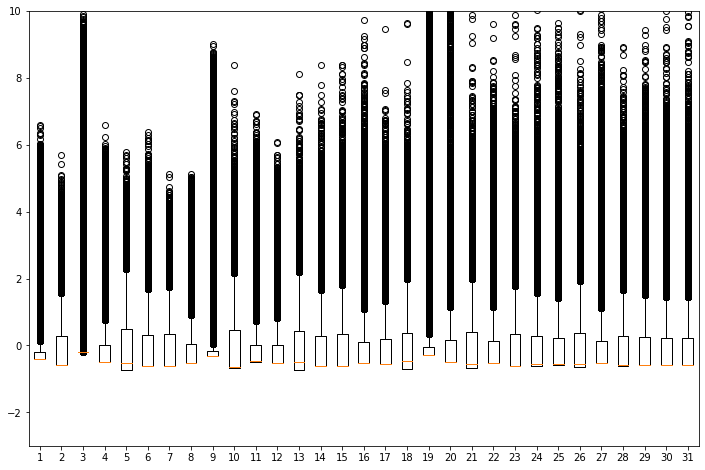

CPU times: user 1.01 s, sys: 63.5 ms, total: 1.07 s
Wall time: 1.08 s


In [5]:
%%time
PNMF = TMG.Layers[0].feature_mat

fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(PNMF)
ax.set_ylim([-3,10])
plt.show()

CPU times: user 16.6 s, sys: 556 ms, total: 17.2 s
Wall time: 17.2 s


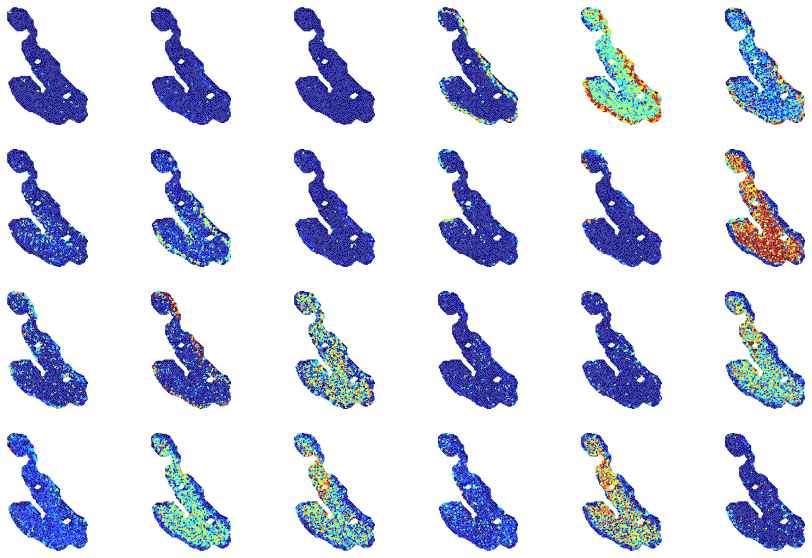

In [6]:
%%time
gs = Viz.GridSpec(4,6)
ViewPNMF = Viz.View(TMG, name='All PNMF', figsize=(15,10))
PNMF = TMG.Layers[0].feature_mat
for i in range(24): 
    to_plot = np.clip(PNMF[:,i],-2,3)
    ViewPNMF.add_panel(Viz.Colorpleth(to_plot, section=0, name=f"PNMF_i", pos=gs[i]))
    ViewPNMF.Panels[i].clrmp='jet'

ViewPNMF.show()    

cannot copy attribute: __weakref__


TypeError: set_ticks() takes 2 positional arguments but 3 were given

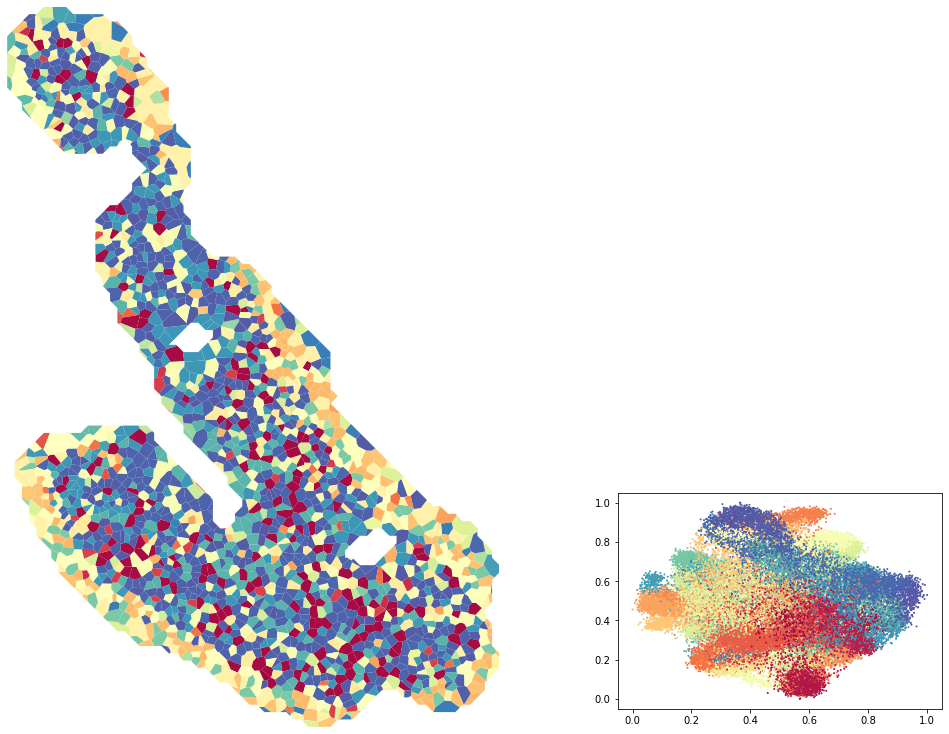

In [7]:
%%time
Vcellmap = Viz.View(TMG, name='cell map with zoom panel', figsize=(15,10))

# Type panel
P_typemap = Viz.TypeMap(
    lvl=0, section=0, pos=(0,0,0.625,1), 
    cmap_list=['Spectral'],#, 'YlOrBr','RdPu','PuBu','YlGn','PiYG','PRGn','cividis','PuOr','cubehelix','RdPu']
    )
Vcellmap.add_panel(P_typemap)

# Zoom panel
P_zoom = Viz.Zoom(P_typemap, 
                  zoom_coords=np.array([0, 2500, 1000, 1000]), 
                  name='zoom', pos=(0.65,0.4,0.3,0.5))
Vcellmap.add_panel(P_zoom)

# Legend panel
P_legend = Viz.LegendWithCircles(P_typemap, name='legend', pos=(0.65,0.025,0.3,0.3), scale=1)
Vcellmap.add_panel(P_legend)
Vcellmap.show()   

In [8]:
self = TMG
layer_id = 2
layer = self.Layers[layer_id]
ntypes = len(np.unique(self.Layers[0].Type))

feature_mat = self.Layers[layer_id].feature_mat
Dtype_pre = np.ones((ntypes,ntypes))-np.diag(np.ones(ntypes))

Dtype = distu.dist_emd(feature_mat, None, Dtype_pre, out_format='squareform')
layer.build_feature_graph(Dtype, metric='precomputed', n_neighbors=5)

/home/haley/dredFISH/dredFISH/Visualization/Viz.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segs = np.array(segs)


TypeError: set_ticks() takes 2 positional arguments but 3 were given

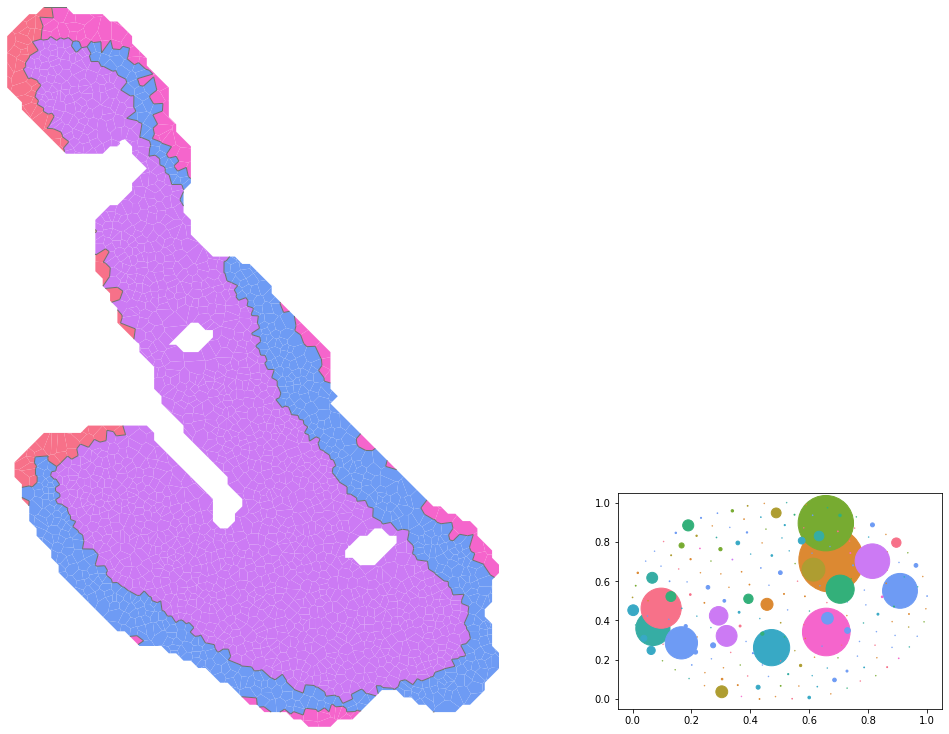

In [9]:
%%time
Vregionmap = Viz.View(TMG, name='region map with circle legend', figsize=(15,10))

# region map
P_regionmap = Viz.TypeMapWithLines(
    lvl=2, section=0, name='region neighborhood map', pos=(0,0,0.625,1), 
    cmap_list=['husl'] #, 'Oranges', 'Purples', 'Blues', 'Reds', 'Greens', 'cividis'],
    )
Vregionmap.add_panel(P_regionmap)

P_legend = Viz.LegendWithCircles(P_regionmap, name='legend', pos=(0.65,0.025,0.3,0.3), scale=100)
Vregionmap.add_panel(P_legend)

P_legend2 = Viz.LegendWithCirclesAndWedges(P_regionmap, P_typemap, name='legend2', pos=(0.65,0.35,0.3,0.45))
Vregionmap.add_panel(P_legend2)

Vregionmap.show()

CPU times: user 676 ms, sys: 32 ms, total: 708 ms
Wall time: 705 ms


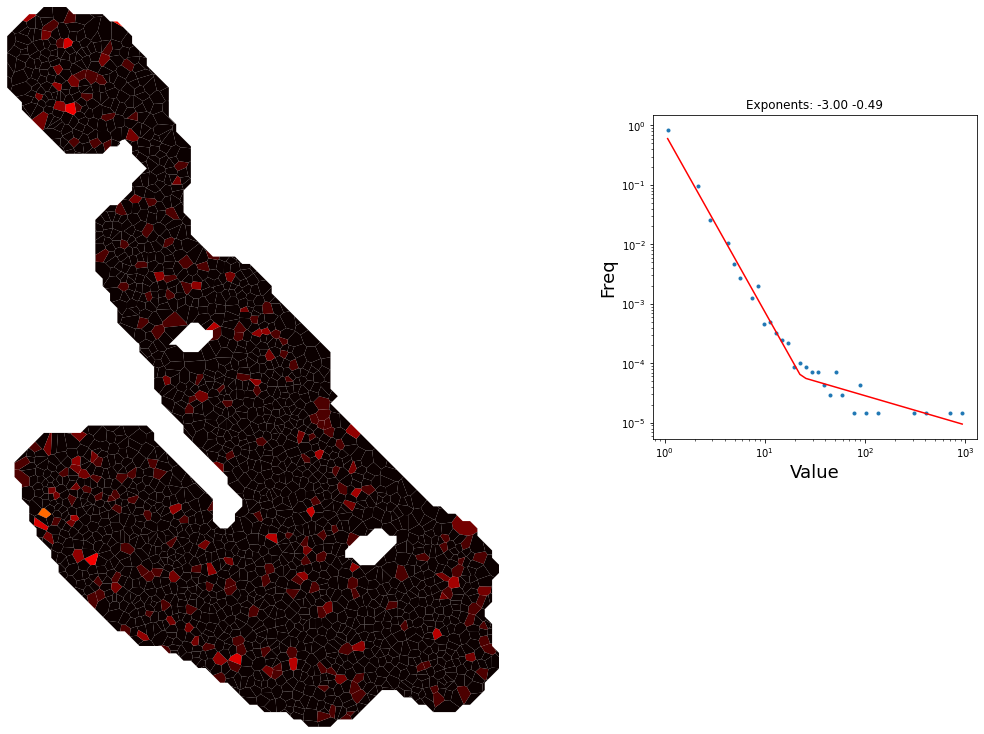

In [10]:
%%time
Vregion_circmap = Viz.View(TMG, name='region map with circle legend', figsize=(15,10))
Vregion_circmap.add_panel(Viz.IsoZones(pos=(0,0,0.66,1), section=0))
P_loglog = Viz.LogLogPlot(TMG.Layers[1].node_size, 
                          pos=(0.7,0.4,0.3,0.45),
                          section=0,
                          )
Vregion_circmap.add_panel(P_loglog)
Vregion_circmap.show()